# Evaluating Performance

In this notebook, we'll evaluate the performance of QRAO by determining how closely it approximates the exact solution to MaxCut for 100 random 3-regular graphs. We'll also compare the performance of QRAO used with two different rounding schemes. In the process, we'll reproduce the main results of [the paper](https://arxiv.org/pdf/2111.03167.pdf) (i.e. Fig. 1).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer

from qrao import (
    QuantumRandomAccessEncoding,
    QuantumRandomAccessOptimizer,
    SemideterministicRounding,
    MagicRounding,
)

from qrao.utils import get_random_maxcut_qp

Let's start with an example: evaluating the performance of QRAO with Pauli rounding at finding the maximal cut of a random 3-regular graph with 8 nodes.

First, we construct a random 3-regular graph with 8 nodes shown below. We define `problem` as the `QuadraticProgram` corresponding to solving MaxCut for this graph.

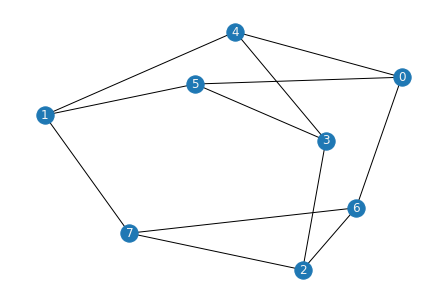

In [2]:
example_problem = get_random_maxcut_qp(degree=3, num_nodes=8, draw=True)

We can get an approximation of the maximal cut of this graph using QRAO by encoding `problem` with a quantum random access code; constructing a `QuantumRandomAccessOptimizer` instance with our encoding, a minimum eigensolver, and the Pauli rounding scheme; solving our `problem` with the optimizer instance; and extracting the optimal function value from the `fval` property.

In [3]:
example_encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
example_encoding.encode(example_problem)
example_qrao = QuantumRandomAccessOptimizer(
    encoding=example_encoding,
    min_eigen_solver=NumPyMinimumEigensolver(),
    rounding_scheme=SemideterministicRounding(),
)
example_found_maxcut = example_qrao.solve(example_problem).fval
example_found_maxcut

20.0

Next, we can compute the exact maximal cut of our graph using CPLEX by constructing a `CplexOptimizer` instance, solving `problem` with the optimizer instance, and extracting the optimal function value from the `fval` property.

In [5]:
example_exact_optimizer = CplexOptimizer()
example_exact_maxcut = example_exact_optimizer.solve(example_problem).fval
example_exact_maxcut

20.0

Finally, we can evaluate the performance of QRAO by determining how closely it approximated the exact maximal cut of our graph. This can be measured using the **approximation ratio**, computed by dividing QRAO's approximate maximal cut by the exact maximal cut. If `approximation_ratio` is `1.0`, then QRAO found the exact maximal cut of the graph; more generally, the closer `approximation_ratio` is to `1.0`, the better QRAO approximated the maximal cut of the graph.

In [6]:
example_approximation_ratio = example_found_maxcut / example_exact_maxcut
example_approximation_ratio

1.0

Now that we know how to evaluate the performance of QRAO for a specific problem, we can generalize by defining a function that can compute the approximation ratio for solving MaxCut for a random 3-regular `num_nodes`-node graph using QRAO with `rounding_scheme` rounding.

In [6]:
exact_optimizer = CplexOptimizer()
min_eigen_solver = NumPyMinimumEigensolver()

In [7]:
def compute_approximation_ratio(num_nodes, rounding_scheme, degree=3):
    problem = get_random_maxcut_qp(degree=degree, num_nodes=num_nodes)

    exact_fval = exact_optimizer.solve(problem).fval

    encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
    encoding.encode(problem)
    qrao = QuantumRandomAccessOptimizer(
        encoding=encoding,
        min_eigen_solver=min_eigen_solver,
        rounding_scheme=rounding_scheme,
    )
    approximate_fval = qrao.solve(problem).fval

    approximation_ratio = approximate_fval / exact_fval

    return approximation_ratio

Finally, we are equipped to evaluate the performance of QRAO by determining how closely it approximates the exact solution to MaxCut for 100 random 3-regular graphs.

There are a couple performance questions we want to investigate:

1. How does the **rounding scheme** affect the performance? Does one rounding scheme outperform another? How does this change for larger graphs?
2. How does the **number of nodes in the graph** affect the performance? Is the performance better/worse for larger graphs? How does this change between rounding schemes?

We can tackle these questions by comparing the distribution of approximation ratio for 100 random 3-regular graphs with 8, 16, 24, 32, 36, and 40 nodes using QRAO with Pauli rounding and magic rounding.

In [8]:
NUM_NODES_LIST = [8, 16, 24, 32, 36, 40]
TRIALS = 100

In [9]:
pauli_rounding = SemideterministicRounding()

backend = Aer.get_backend("aer_simulator")
rounding_qi = QuantumInstance(backend=backend, shots=1)

magic_rounding = MagicRounding(rounding_qi)

In [10]:
pauli_rounding_approximation_ratios = {
    num_nodes: [
        compute_approximation_ratio(num_nodes, pauli_rounding)
        for _ in tqdm(range(TRIALS))
    ]
    for num_nodes in NUM_NODES_LIST
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Here we can see the approximation ratio distribution for using **QRAO with Pauli rounding** to solve 100 random 3-regular graph MaxCut instances for different graph sizes.

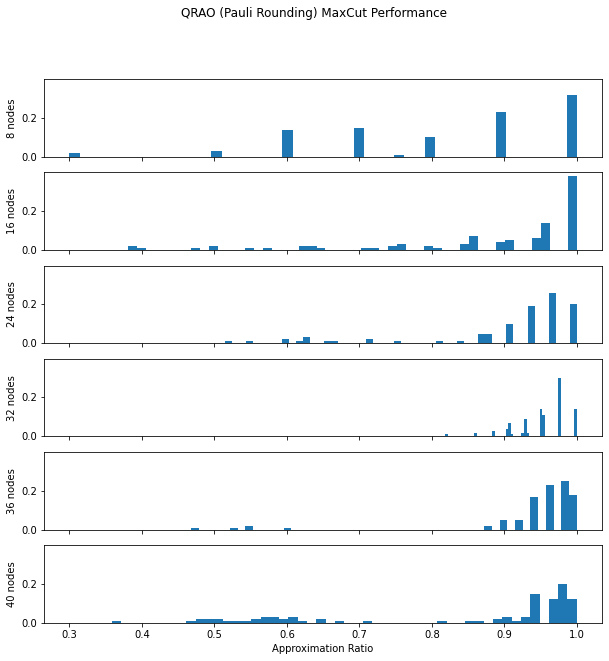

In [22]:
fig, axes = plt.subplots(len(NUM_NODES_LIST), sharex=True, sharey=True)

fig.set_size_inches(10, 10)

for i, num_nodes in enumerate(NUM_NODES_LIST):
    axes[i].hist(
        pauli_rounding_approximation_ratios[num_nodes],
        weights=np.zeros_like(pauli_rounding_approximation_ratios[num_nodes])
        + 1.0 / TRIALS,
        bins=50,
    )
    axes[i].set_ylabel(f"{num_nodes} nodes")

fig.suptitle("QRAO (Pauli Rounding) MaxCut Performance")
plt.xlabel("Approximation Ratio")

plt.show()

In [12]:
magic_rounding_approximation_ratios = {
    num_nodes: [
        compute_approximation_ratio(num_nodes, magic_rounding)
        for _ in tqdm(range(TRIALS))
    ]
    for num_nodes in NUM_NODES_LIST
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

And here we can see the approximation ratio distribution for using **QRAO with magic rounding** to solve 100 random 3-regular graph MaxCut instances for different graph sizes.

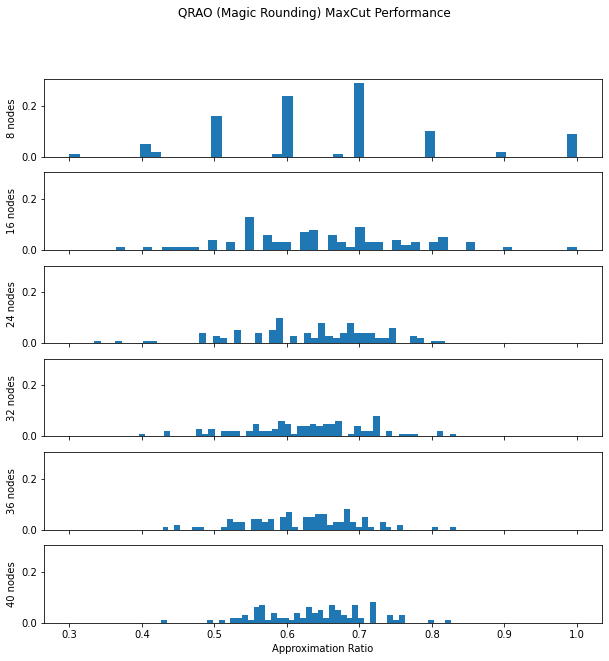

In [23]:
fig, axes = plt.subplots(len(NUM_NODES_LIST), sharex=True, sharey=True)

fig.set_size_inches(10, 10)

for i, num_nodes in enumerate(NUM_NODES_LIST):
    axes[i].hist(
        magic_rounding_approximation_ratios[num_nodes],
        weights=np.zeros_like(magic_rounding_approximation_ratios[num_nodes])
        + 1.0 / TRIALS,
        bins=50,
    )
    axes[i].set_ylabel(f"{num_nodes} nodes")

fig.suptitle("QRAO (Magic Rounding) MaxCut Performance")
plt.xlabel("Approximation Ratio")

plt.show()

These two graphs constitute the main results of [the paper](https://arxiv.org/pdf/2111.03167.pdf) (i.e. Fig. 1).

To summarize the information in the two graphs, we can additionally plot the median approximation ratio for Pauli rounding and magic rounding as a function of the number of nodes in the graph. This gives us a sense both of how well QRAO with Pauli rounding and with magic rounding each solve MaxCut overall, and how their performances change as the graph grows.

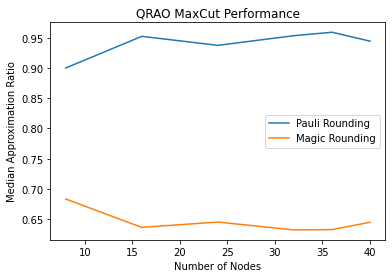

In [24]:
plt.plot(
    NUM_NODES_LIST,
    [
        np.median(pauli_rounding_approximation_ratios[num_nodes])
        for num_nodes in NUM_NODES_LIST
    ],
    label="Pauli Rounding",
)
plt.plot(
    NUM_NODES_LIST,
    [
        np.median(magic_rounding_approximation_ratios[num_nodes])
        for num_nodes in NUM_NODES_LIST
    ],
    label="Magic Rounding",
)
plt.title("QRAO MaxCut Performance")
plt.xlabel("Number of Nodes")
plt.ylabel("Median Approximation Ratio")
plt.legend()
plt.show()